# Implementation of infoGANs
Reference: https://arxiv.org/pdf/1606.03657.pdf

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [3]:
import numpy as np
import datetime
import scipy.misc

In [4]:
def get_sample_image():
    """
        save sample 100 images
    """
    images = []
    # continuous code
    for cc_type in range(2):
        for num in range(10):
            fix_z = torch.randn(1, n_noise)
            z = to_cuda_var(fix_z)
            cc = -1
            for i in range(10):
                cc += 0.2
                c_discrete = to_cuda_var(to_onehot(num)) # (B,10)
                c_continuous = to_cuda_var(torch.zeros(1, n_c_continuous))
                c_continuous.data[:,cc_type].add_(cc)
                c = torch.cat((c_discrete.float(), c_continuous), 1)
                y_hat = G(z, c)
                line_img = torch.cat((line_img, y_hat.view(28, 28)), dim=1) if i > 0 else y_hat.view(28, 28)
            all_img = torch.cat((all_img, line_img), dim=0) if num > 0 else line_img
        img = all_img.cpu().data.numpy()
        images.append(img)
    # discrete code
    for num in range(10):
        c_discrete = to_cuda_var(to_onehot(num)) # (B,10)
        for i in range(10):
            z = to_cuda_var(torch.randn(1, n_noise))
            c_continuous = to_cuda_var(torch.zeros(1, n_c_continuous))
            c = torch.cat((c_discrete.float(), c_continuous), 1)
            y_hat = G(z, c)
            line_img = torch.cat((line_img, y_hat.view(28, 28)), dim=1) if i > 0 else y_hat.view(28, 28)
        all_img = torch.cat((all_img, line_img), dim=0) if num > 0 else line_img
    img = all_img.cpu().data.numpy()
    images.append(img)
    return images[0], images[1], images[2]

In [5]:
def to_cuda_var(x):
    if torch.cuda.is_available():
        return Variable(x).cuda()
    return Variable(x)

In [6]:
def to_onehot(x, num_classes=10):
    assert isinstance(x, int) or isinstance(x, (torch.LongTensor, torch.cuda.LongTensor))
    if isinstance(x, int):
        c = torch.zeros(1, num_classes).long()
        c[0][x] = 1
    else:
        x = x.cpu()
        c = torch.LongTensor(x.size(0), num_classes)
        c.zero_()
        c.scatter_(1, x, 1) # dim, index, src value
    return c

In [7]:
def sample_noise(batch_size, n_noise, n_c_discrete, n_c_continuous, label=None, supervised=False):
    z = to_cuda_var(torch.randn(batch_size, n_noise))
    if supervised:
        c_discrete = to_cuda_var(to_onehot(label)) # (B,10)
    else:
        c_discrete = to_cuda_var(to_onehot(torch.LongTensor(batch_size, 1).random_(0, n_c_discrete))) # (B,10)
    c_continuous = to_cuda_var(torch.zeros(batch_size, n_c_continuous).uniform_(-1, 1)) # (B,2)
    c = torch.cat((c_discrete.float(), c_continuous), 1)
    return z, c

In [8]:
def log_gaussian(c, mu, var):
    """
        criterion for Q(condition classifier)
    """
    return -((c - mu)**2)/(2*var+1e-8) - 0.5*torch.log(2*np.pi*var+1e-8)

In [9]:
class Discriminator(nn.Module):
    """
        Convolutional Discriminator for MNIST
    """
    def __init__(self, in_channel=1):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(# 28 -> 14
            nn.Conv2d(in_channel, 64, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
        )
        self.layer2 = nn.Sequential(# 14 -> 7
            nn.Conv2d(64, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
        )
        self.layer3 = nn.Sequential(#
            nn.Linear(128*7*7, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.1),
        )
        self.fc = nn.Sequential(
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        y_ = self.layer1(x)
        y_ = self.layer2(y_)
        y_ = y_.view(y_.size(0), -1)
        y_ = self.layer3(y_)
        d = self.fc(y_) # Real / Fake        
        return d, y_ # return with top layer features for Q

In [13]:
class Qrator(nn.Module):
    """
        Regularization Network for increasing Mutual Information
    """
    def __init__(self):
        super(Qrator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(1024, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 14),
        )
        
    def forward(self, x):
        # Seperate code
        c = self.fc(x)
        c_discrete = F.softmax(c[:, :10]) # Digit Label {0~9}
        c_mu = c[:, 10:12] # mu & var of Rotation & Thickness
        c_var = c[:, 12:14].exp() # mu & var of Rotation & Thickness
        return c_discrete, c_mu, c_var

In [11]:
class Generator(nn.Module):
    """
        Convolutional Generator for MNIST
    """
    def __init__(self, input_size=62, code_size=12, num_classes=784):
        super(Generator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_size+code_size, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Linear(1024, 7*7*128),
            nn.BatchNorm1d(7*7*128),
            nn.ReLU(),
        )
        self.layer3 = nn.Sequential(# input: 7 by 7, output: 14 by 14
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer4 = nn.Sequential(# input: 14 by 14, output: 28 by 28
            nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )
        
    def forward(self, z, c):
        z = z.view(z.size(0), -1)
        c = c.view(c.size(0), -1)
        noise = torch.cat((z, c), 1)
#         print(noise.size())
        x_ = self.layer1(noise)
        x_ = self.layer2(x_)
        x_ = x_.view(x_.size(0), 128, 7, 7)
        x_ = self.layer3(x_)
        x_ = self.layer4(x_)
        return x_

In [14]:
D = Discriminator().cuda()
G = Generator().cuda()
Q = Qrator().cuda()
# D.load_state_dict('D_dc.pkl')
# G.load_state_dict('G_dc.pkl')

In [15]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                std=(0.5, 0.5, 0.5))]
)

In [16]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

In [17]:
batch_size = 128

In [18]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

In [19]:
bce_loss = nn.BCELoss()
ce_loss = nn.CrossEntropyLoss()

D_opt = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.99))
# G_opt = torch.optim.Adam(G.parameters(), lr=1e-3, betas=(0.5, 0.99))
G_opt = torch.optim.Adam([{'params':G.parameters()}, {'params':Q.parameters()}], lr=1e-3, betas=(0.5, 0.99))

In [20]:
max_epoch = 105 # need more than 20 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_noise = 62
n_c_discrete, n_c_continuous = 10, 2

D_labels = to_cuda_var(torch.ones(batch_size)) # Discriminator Label to real
D_fakes = to_cuda_var(torch.zeros(batch_size)) # Discriminator Label to fake

In [22]:
for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(data_loader):
        step += 1
        labels = labels.view(batch_size, 1)
        # Training Discriminator
        x = to_cuda_var(images)
        x_outputs, _, = D(x)
        D_x_loss = bce_loss(x_outputs, D_labels)

        z, c = sample_noise(batch_size, n_noise, n_c_discrete, n_c_continuous, label=labels, supervised=True)
        z_outputs, _, = D(G(z, c))
        D_z_loss = bce_loss(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss
        
        D_opt.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step > 500:
            # Training Generator
            z, c = sample_noise(batch_size, n_noise, n_c_discrete, n_c_continuous, label=labels, supervised=True)
            c_discrete_label = torch.max(c[:, :-2], 1)[1].view(-1, 1)
            
            z_outputs, features = D(G(z, c)) # (B,1), (B,10), (B,4)
            c_discrete_out, cc_mu, cc_var = Q(features)
            
            G_loss = bce_loss(z_outputs, D_labels)
            Q_loss_discrete = ce_loss(c_discrete_out, c_discrete_label.view(-1))
            Q_loss_continuous = -torch.mean(torch.sum(log_gaussian(c[:, -2:], cc_mu, cc_var), 1)) # N(x | mu,var) -> (B, 2) -> (,1)

            GnQ_loss = G_loss + Q_loss_discrete + Q_loss_continuous*0.1

            G_opt.zero_grad()
            GnQ_loss.backward()
            G_opt.step()
        
        if step % 1000 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}, DnQ Loss: {}, Time: {}'\
                  .format(epoch, max_epoch, step, D_loss.data[0], G_loss.data[0], GnQ_loss.data[0], str(datetime.datetime.today())[:-7]))
            
        if epoch % 5 == 0:
            G.eval()
            img1, img2, img3 = get_sample_image()
            scipy.misc.imsave('sample2/epoch_{}_type1.jpg'.format(epoch), img1)
            scipy.misc.imsave('sample2/epoch_{}_type2.jpg'.format(epoch), img2)
            scipy.misc.imsave('sample2/epoch_{}_type3.jpg'.format(epoch), img3)
            G.train()

/home/yangyangii/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1189: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/home/yangyangii/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/yangyangii/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/yangyangii/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`

Epoch: 2/200, Step: 1000, D Loss: 0.3780098557472229, G Loss: 1.7853507995605469, Q Loss: 3.8619868755340576, Time: 2018-05-05 19:24:50
Epoch: 4/200, Step: 2000, D Loss: 0.7211685180664062, G Loss: 1.691239833831787, Q Loss: 3.3395743370056152, Time: 2018-05-05 19:25:19
Epoch: 6/200, Step: 3000, D Loss: 0.7582706212997437, G Loss: 1.412711501121521, Q Loss: 3.0302205085754395, Time: 2018-05-05 19:28:41
Epoch: 8/200, Step: 4000, D Loss: 0.6191341876983643, G Loss: 1.6487994194030762, Q Loss: 3.2237048149108887, Time: 2018-05-05 19:29:10
Epoch: 10/200, Step: 5000, D Loss: 0.7058660387992859, G Loss: 1.470022439956665, Q Loss: 3.007896661758423, Time: 2018-05-05 19:31:42
Epoch: 12/200, Step: 6000, D Loss: 1.1128296852111816, G Loss: 1.6825504302978516, Q Loss: 3.2425475120544434, Time: 2018-05-05 19:32:59
Epoch: 14/200, Step: 7000, D Loss: 0.5996794700622559, G Loss: 1.8286118507385254, Q Loss: 3.3309996128082275, Time: 2018-05-05 19:33:28
Epoch: 17/200, Step: 8000, D Loss: 0.667932629585

Epoch: 130/200, Step: 61000, D Loss: 0.22682470083236694, G Loss: 4.091072082519531, Q Loss: 5.571869850158691, Time: 2018-05-05 20:38:59
Epoch: 132/200, Step: 62000, D Loss: 0.13977500796318054, G Loss: 5.321469306945801, Q Loss: 6.768302917480469, Time: 2018-05-05 20:40:29
Epoch: 134/200, Step: 63000, D Loss: 0.12810447812080383, G Loss: 5.937180995941162, Q Loss: 7.402705192565918, Time: 2018-05-05 20:40:53
Epoch: 136/200, Step: 64000, D Loss: 0.19408255815505981, G Loss: 5.489245891571045, Q Loss: 6.945627212524414, Time: 2018-05-05 20:42:53
Epoch: 138/200, Step: 65000, D Loss: 0.15603268146514893, G Loss: 5.0622878074646, Q Loss: 6.530234336853027, Time: 2018-05-05 20:43:18
Epoch: 141/200, Step: 66000, D Loss: 0.18864531815052032, G Loss: 5.30040168762207, Q Loss: 6.7147650718688965, Time: 2018-05-05 20:45:16
Epoch: 143/200, Step: 67000, D Loss: 0.1315631866455078, G Loss: 6.050332546234131, Q Loss: 7.509021759033203, Time: 2018-05-05 20:45:41
Epoch: 145/200, Step: 68000, D Loss: 

# Sample

/home/yangyangii/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  This is separate from the ipykernel package so we can avoid doing imports until


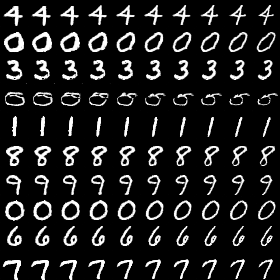

In [24]:
# generation to image
G.eval()
scipy.misc.toimage(get_sample_image()[0])

/home/yangyangii/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  """Entry point for launching an IPython kernel.


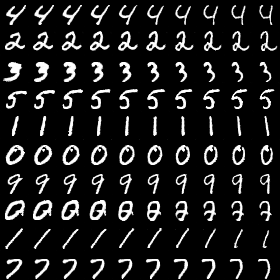

In [25]:
scipy.misc.toimage(get_sample_image()[1])

In [81]:
def save_checkpoint(state, file_name='checkpoint.pth.tar'):
    torch.save(state, file_name)

In [82]:
# Saving params.
# torch.save(D.state_dict(), 'D_c.pkl')
# torch.save(G.state_dict(), 'G_c.pkl')
save_checkpoint({'epoch': epoch + 1, 'state_dict':DnQ.state_dict(), 'optimizer' : DnQ_opt.state_dict()}, 'DnQ_info.pth.tar')
save_checkpoint({'epoch': epoch + 1, 'state_dict':G.state_dict(), 'optimizer' : G_opt.state_dict()}, 'G_info.pth.tar')